In [1]:
import torch

from torch import nn
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
# CUDA is not necessary for the examples in this notebook.
torch.has_cuda

False

## Create a Custom PyTorch Model

* Inherit from `nn.Module`.
* Don't forget `super(ModelName, self).__init__()`.
* Define all layers in `__init__()`.
* Construct forward pass in `forward(self, x)`. You can use as many arguments as you wish. Usually one is enough :)

In [3]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.neuron = nn.Linear(1, 1)
        
    def forward(self, x):
        return self.neuron(x)

`MyModel` is not very interesting, it is just `y = mx + b`. If you want to build a real neural network you would require more [layers](https://pytorch.org/docs/stable/nn.html) and some [non-linearities](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) (e.g. ReLU). 

Usually each layer is put through a non-linearity:

```
def forward(self, x):
    return F.relu(self.neuron(x))
```

You can reuse `x` during the forward pass:
```
def forward(self, x):
    x = F.relu(self.neuron(x))
    x = F.relu(self.another_neuron(x))
    return x
```

## Does MyModel work?

The first step after defining is to test `forward`. We define a single instance `x`, which can be anything as long as the dimensions are correct. In case of `MyModel` we want to have input dimensions `N x 1` and obtain outputs of same dimensionality.

In [4]:
x = np.array([[1,2,3,4]])
print(type(x))

# convert from numpy to torch
x = torch.from_numpy(x)
print(type(x))

<class 'numpy.ndarray'>
<class 'torch.Tensor'>


In [5]:
model = MyModel()

In [6]:
model

MyModel(
  (neuron): Linear(in_features=1, out_features=1, bias=True)
)

In [7]:
model(x)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x4 and 1x1)

__Note:__ This did not work out. Something with the tensor-shapes is wrong. 

In [8]:
x.shape

torch.Size([1, 4])

Our input x has dimensionality `1 x N` instead of `N x 1`. 

In [9]:
# Now we define our x the correct way:
x = np.array([[1], [2], [3], [4]], dtype=np.float32)
x = torch.from_numpy(x)
x.shape

torch.Size([4, 1])

In [10]:
y = model(x)

In [11]:
y

tensor([[-1.7247],
        [-2.4967],
        [-3.2687],
        [-4.0406]], grad_fn=<AddmmBackward>)

`y` has a `grad_fn`, which means that you can use the auto-grad framework of pytorch to compute the backward pass and train the model. In other words the variable `y` is attached to the computation graph and you can train it.

If you want to plot `y` with matplotlib you have to `detach` `y` first.

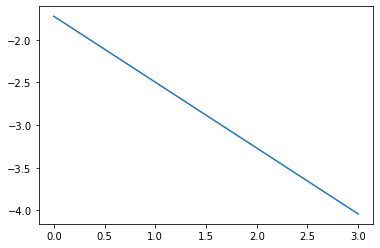

In [12]:
plt.plot(y.detach())

Matplotlib is clever enough to handle `torch.tensors`, but if you want to get an numpy-array you can just call `.numpy()` on the tensor.

In [13]:
y.detach().numpy()

array([[-1.7247454],
       [-2.4967093],
       [-3.2686732],
       [-4.040637 ]], dtype=float32)

## Train MyModel

Next we want to generate some GT line-data and simulate noisy measurements from it. With these measurments we train our model and fit a line.

In [14]:
m = 1.2
b = -4.

In [15]:
# Train-Data
x = np.linspace(-1,1,100, dtype=np.float32)
gt = m*x + b
y = np.random.normal(gt, 1.).astype(np.float32)

In [16]:
# Note that the shapes are not correct yet.
print(x.shape, y.shape)

(100,) (100,)


In [17]:
x = x[:, np.newaxis]
y = y[:, np.newaxis]
print(x.shape, y.shape)

(100, 1) (100, 1)


In [18]:
x_torch = torch.from_numpy(x)
y_torch = torch.from_numpy(y)

In [19]:
# Test-Data
test_x = torch.from_numpy(np.array([[-2], [2]], dtype=np.float32))

In [20]:
pred_untrained = model(test_x)

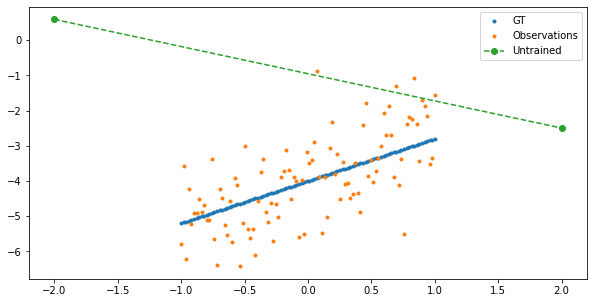

In [21]:
plt.figure(figsize=(10,5))
plt.plot(x, gt, '.', label='GT')
plt.plot(x, y, '.', label='Observations')
plt.plot(test_x, pred_untrained.detach(), 'o--', label='Untrained')
plt.legend();

### Loss-Function

In [22]:
loss_function = F.mse_loss

### Optimizer

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Train-Function

This is a very simple train function i.e. without dataloaders and batching. We just iterate over all samples one-by-one (batch-size = 1).

In [24]:
# Since we loop over x, the dimension gets reduced by one:
for x_ in x_torch:
    print(x_.shape)
    break

torch.Size([1])


In [25]:
# Hence we have to use unsqueeze to add a singleton dimension:
for x_ in x_torch:
    x_ = x_.unsqueeze(0)
    print(x_.shape)
    break

torch.Size([1, 1])


In [26]:
def train(model, x, y, loss_function, optimizer, num_epochs):
    # Make sure that the model is in train-mode
    model.train()
    
    running_loss = 0.0
    for e in tqdm(range(num_epochs)):
        for x_, y_ in zip(x, y):
            x_ = x_.unsqueeze(0) 
            y_ = y_.unsqueeze(0)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_hat = model(x_)
            loss = loss_function(y_hat, y_)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() # .item() returns the scalar value of the tensor.
            
        running_loss /= len(x)
        if e % 100 == 0:
            running_loss /= 100.
            print('Epoch: {:4}; Train-Loss: {}'.format(e, np.round(running_loss, 3)))
            running_loss = 0.0

In [27]:
train(model, x_torch, y_torch, loss_function, optimizer, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:    0; Train-Loss: 0.116
Epoch:  100; Train-Loss: 0.068
Epoch:  200; Train-Loss: 0.036
Epoch:  300; Train-Loss: 0.018
Epoch:  400; Train-Loss: 0.011
Epoch:  500; Train-Loss: 0.01
Epoch:  600; Train-Loss: 0.009
Epoch:  700; Train-Loss: 0.009
Epoch:  800; Train-Loss: 0.009
Epoch:  900; Train-Loss: 0.009


In [28]:
model.eval();

In [29]:
pred = model(test_x)

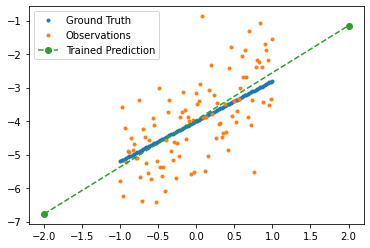

In [30]:
plt.plot(x, gt, '.', label='Ground Truth')
plt.plot(x, y, '.', label='Observations')
plt.plot(test_x, pred.detach(), 'o--', label='Trained Prediction')
plt.legend();

In [31]:
print('GT line:        y = {:2.2f}*x + {:2.2f}'.format(m, b))
print('Predicted line: y = {:2.2f}*x + {:2.2f}'.format(model.neuron.weight.item(), model.neuron.bias.item()))

GT line:        y = 1.20*x + -4.00
Predicted line: y = 1.40*x + -3.96
